In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pydicom

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train"
TEST_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test"
BASE_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection"

In [3]:
train = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")

In [4]:
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".dcm")
train['type'] = train['ID'].apply(lambda st: st.split('_')[2])
train = train[['Label', 'filename', 'type']].drop_duplicates().pivot(index='filename', columns='type', values='Label').reset_index()

In [5]:
train.head(-1)

type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.dcm,0,0,0,0,0,0
1,ID_000039fa0.dcm,0,0,0,0,0,0
2,ID_00005679d.dcm,0,0,0,0,0,0
3,ID_00008ce3c.dcm,0,0,0,0,0,0
4,ID_0000950d7.dcm,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752797,ID_ffff80705.dcm,0,0,0,0,0,0
752798,ID_ffff82e46.dcm,0,0,0,0,0,0
752799,ID_ffff922b9.dcm,1,0,0,1,0,0
752800,ID_ffffb670a.dcm,1,0,0,0,1,0


In [6]:
train_any0 = train[train['any'] == 1]["filename"]
train_normal = train[train['any'] == 0]["filename"]

In [7]:
train_hem = train_any0[0:50000]
train_normal = train_normal[0:50000]

In [8]:
windows = [(40,80) , (80,200) , (40,380)]
window_names =  ['Brain_Window' , 'Subdural_Window' , 'Soft_Tissue_Window','3d'] 

In [9]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    a = [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
    return a

In [10]:
def create_filter(image , rad_in , rad_out , in_val , out_val , mid_val):
    if(rad_in > rad_out):
        a = rad_in+rad_out
        rad_out = a - rad_out
        rad_in  = a - rad_in
    rows , cols = image.shape
    crow,ccol   = int(rows/2) , int(cols/2)
    
    if(out_val == 1):
        mask = np.ones((rows,cols,2),np.uint8)
    else:
        mask = np.zeros((rows,cols,2),np.uint8)
        
    center = [crow,ccol]
    
    x,y = np.ogrid[:rows , :cols]
    
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= rad_out**2
    mask[mask_area] = mid_val
    
    mask_area = mask_area = (x - center[0])**2 + (y - center[1])**2 <= rad_in**2
    mask[mask_area] = in_val
    
    print(mask_area.shape)
    
    return mask



def gaussian_filter(image , radius):
    
    
    M , N = image.shape
    H = np.zeros((M,N,2) , dtype = np.float32)
    
    for u in range(M):
        for v in range(N):
            
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v,:] = np.exp(-D**2/(2*radius*radius))
            
    return H

In [11]:
import cv2

def modify_image(image): 
    brain_window = image
    mask = gaussian_filter(image , 3)


    fourier = cv2.dft(np.float32(brain_window), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)

    # calculate the magnitude of the Fourier Transform
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))

    # Scale the magnitude for display
    normal_fft = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)


    mod_image = fourier_shift * mask

    mod_image_mag = 20*np.log(cv2.magnitude(mod_image[:,:,0],mod_image[:,:,1]))


    fft_ifft_shift = np.fft.ifftshift(mod_image)
    imageThen = cv2.idft(fft_ifft_shift)
    imageThen = imageThen/imageThen.max()

    # calculate the magnitude of the inverse DFT
    imageThen = cv2.magnitude(imageThen[:,:,0], imageThen[:,:,1])
    
    D = brain_window - imageThen

    alpha = np.mean(np.abs(D))/np.abs(D).max()

    T = alpha*np.abs(D).max()

    D_T = np.zeros((512,512) , dtype = np.float32)
    for u in range(512):
        for v in range(512):
            if np.abs(D[u,v]) >= T:
                D_T[u,v] = D[u,v]
            else:
                D_T[u,v] = 0

    labmda = 4
    um_sharp = brain_window + labmda*D_T

    return um_sharp








In [12]:
def pllot(image , modify_image):
    plt.figure(figsize=(20,50))
    plt.subplots_adjust(
                    
                    wspace=0,
                    hspace=0)
    z = 1
    for i in range(4):
        for j in range(2):
            if(j == 0):
                plt.subplot(4,2,z) , plt.imshow(image[window_names[i]], cmap= plt.cm.bone)
                plt.title('Normal'), plt.xticks([]), plt.yticks([])
                z +=1
            else:
                plt.subplot(4,2,z) , plt.imshow(modify_image[window_names[i]], cmap= plt.cm.bone)
                plt.title('Modified'), plt.xticks([]), plt.yticks([])
                z +=1
    plt.show()      

In [13]:
def final_image_gen(file_name):
    final_image = np.ones((512,512,3) , dtype = np.float32)
    image = pydicom.read_file(os.path.join(TRAIN_IMG_PATH, file_name))
    [window_center , window_width, intercept, slope] = get_windowing(image)
    image = image.pixel_array
    for i in range(3):
        final_image[:,:,i] = modify_image(window_image(image, windows[i][0] , windows[i][1] , intercept , slope))
        
        
    return final_image

In [14]:
def image_gen(file_name):
    final_image = np.ones((512,512,3) , dtype = np.float32)
    image = pydicom.read_file(os.path.join(TRAIN_IMG_PATH, file_name))
    [window_center , window_width, intercept, slope] = get_windowing(image)
    image = image.pixel_array
    
    if(image.shape == (512,512)):
        for i in range(3):
            final_image[:,:,i] = window_image(image, windows[i][0] , windows[i][1] , intercept , slope)

        
    
        
        
    return final_image

In [30]:
image1 = train_normal[0]

In [32]:
image  = image_gen(image1)

In [33]:
modified_image = final_image_gen(image1)

(Text(0.5, 1.0, 'Normal'), ([], []), ([], []))

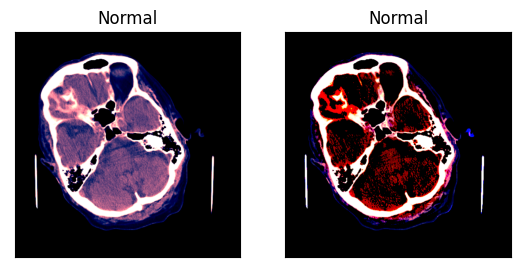

In [34]:
plt.subplot(1,2,1) , plt.imshow(image, cmap= plt.cm.bone)
plt.title('Normal'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2) , plt.imshow(modified_image, cmap= plt.cm.bone)
plt.title('Normal'), plt.xticks([]), plt.yticks([])

In [39]:
image_hem = train_any0[14]

In [40]:
image_hem1 = image_gen(image_hem)
mod_image_hem = final_image_gen(image_hem)

(Text(0.5, 1.0, 'Normal'), ([], []), ([], []))

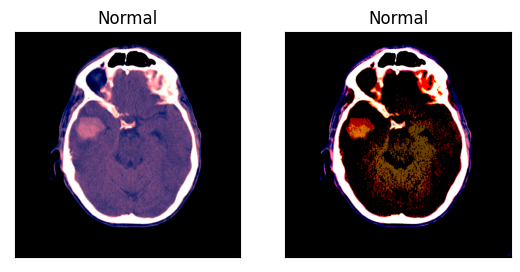

In [41]:
plt.subplot(1,2,1) , plt.imshow(image_hem1, cmap= plt.cm.bone)
plt.title('Normal'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2) , plt.imshow(mod_image_hem, cmap= plt.cm.bone)
plt.title('Normal'), plt.xticks([]), plt.yticks([])